## importing libraries

In [51]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import f_classif, chi2
import tensorflow as tf
from kerastuner import RandomSearch

/tmp/ipython-input-2797576801.py:14: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


## Loadig Data

In [5]:
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
data = pd.read_csv(url)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Cleaning

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


*   No need for Passenger ID
*   Survived is the target
*   Pclass is good to know the high class could be more safe
*   No Need for the name
*   Sex matters as Mans stronger to survive
*   Older mens hard to survive them selves
*   SipSp If u have some one with u have to save them too
*   Parch same as SipSp
*   Ticket doesn't matter
*   Fare same as Pclass
*   Cabin is null
*   Emparked may the palce differs


In [7]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_')
data.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [9]:
data['family_size'] = data['sibsp'] + data['parch'] + 1

In [10]:
df = data.drop(['passengerid', 'name', 'ticket', 'cabin', 'sibsp', 'parch'], axis=1)
df.head()

,survived,pclass,sex,age,fare,embarked,family_size
0,0,3,male,22.0,7.2500,S,2
1,1,1,female,38.0,71.2833,C,2
2,1,3,female,26.0,7.9250,S,1
3,1,1,female,35.0,53.1000,S,2
4,0,3,male,35.0,8.0500,S,1


## EDA

In [11]:
num_columns= ['age', 'fare']
catready_columns= ['pclass', 'family_size']
cat_columns= ['pclass', 'sex', 'embarked']
cats = cat_columns + catready_columns

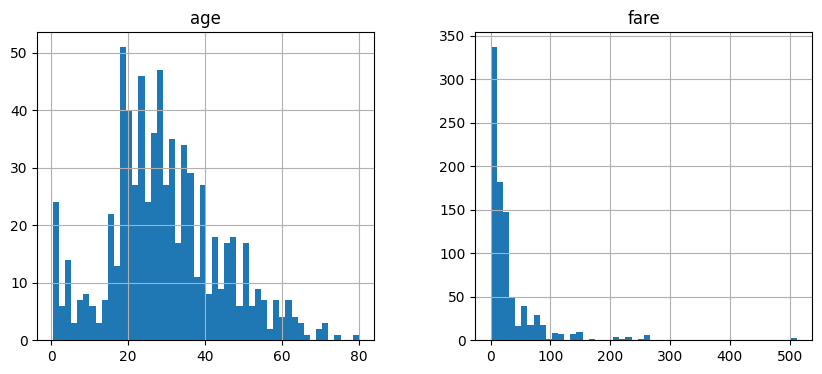

In [12]:
df[num_columns].hist(figsize=(10, 4), bins=50)
plt.show()

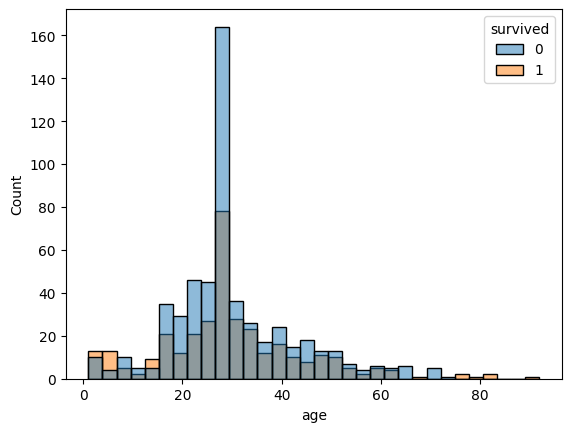

In [13]:
df['age'] = df['age'].apply(lambda x: x * 100 if x < 1 else x)
df['age'] = df['age'].fillna(df['age'].median())
df['age'] = df['age'].astype(int)
sns.histplot(data = df ,x = 'age', hue = 'survived', )
plt.show()

In [14]:
df = df[df['fare'] < 500]

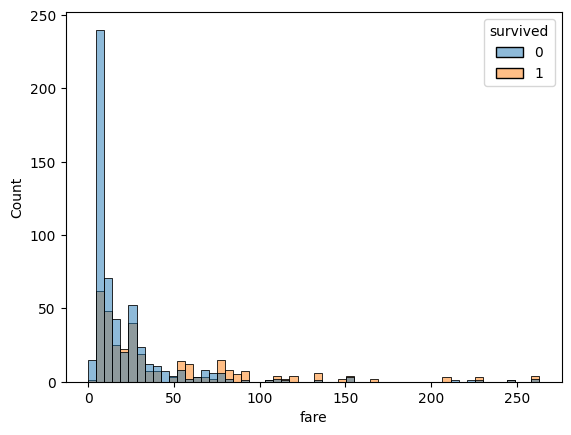

In [15]:
sns.histplot(data = df ,x = 'fare', hue = 'survived' )
plt.show()

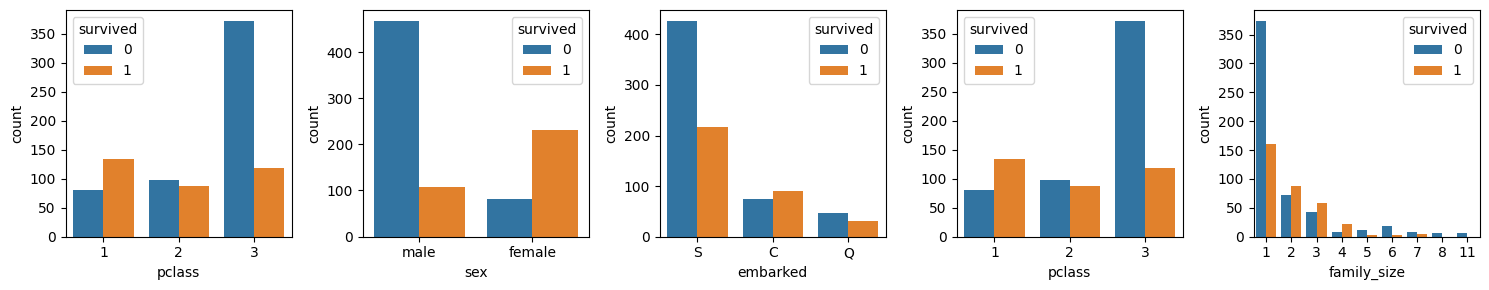

In [16]:
_, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, x in enumerate(cats):
  sns.countplot(data = df, x = x,hue='survived', ax=axes[i])
plt.tight_layout()
plt.show()

In [17]:
df['emarked'] = df['embarked'].fillna(df['embarked'].mode()[0])

## Data split & Preprocessing

In [18]:
X = df.drop('survived', axis=1)
y = df['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=42)

In [19]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])
ready_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_columns),
    ('cat' , cat_pipeline, cat_columns),
    ('ready', ready_pipeline, catready_columns)
])

X_train_final = preprocessor.fit_transform(X_train)
X_test_final = preprocessor.transform(X_test)

X_train_final.shape , y_train.shape, X_test_final.shape , y_test.shape

((710, 12), (710,), (178, 12), (178,))

In [20]:
models_path = os.path.join(os.getcwd(), 'models')
os.makedirs(models_path, exist_ok=True)
joblib = joblib.dump(preprocessor, os.path.join(models_path, 'preprocessor.pkl'))

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_final.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,033 (47.00 KB)

 Trainable params: 12,033 (47.00 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_final, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.5227 - loss: 0.6967 - val_accuracy: 0.7254 - val_loss: 0.5975
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6867 - loss: 0.5855 - val_accuracy: 0.7394 - val_loss: 0.5498
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7861 - loss: 0.5044 - val_accuracy: 0.7465 - val_loss: 0.5112
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7976 - loss: 0.4357 - val_accuracy: 0.7887 - val_loss: 0.4935
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8470 - loss: 0.3991 - val_accuracy: 0.7746 - val_loss: 0.4797
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8161 - loss: 0.4248 - val_accuracy: 0.6972 - val_loss: 0.5494
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8130 - loss: 0.4229 - val_accuracy: 0.7676 - val_loss: 0.4933
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8364 - loss: 0.3868 - val_accuracy: 0.7746 - val_loss

In [23]:
test_loss , test_acc = model.evaluate(X_test_final, y_test)
test_loss , test_acc

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7926 - loss: 0.4613


(0.5283429622650146, 0.8033707737922668)

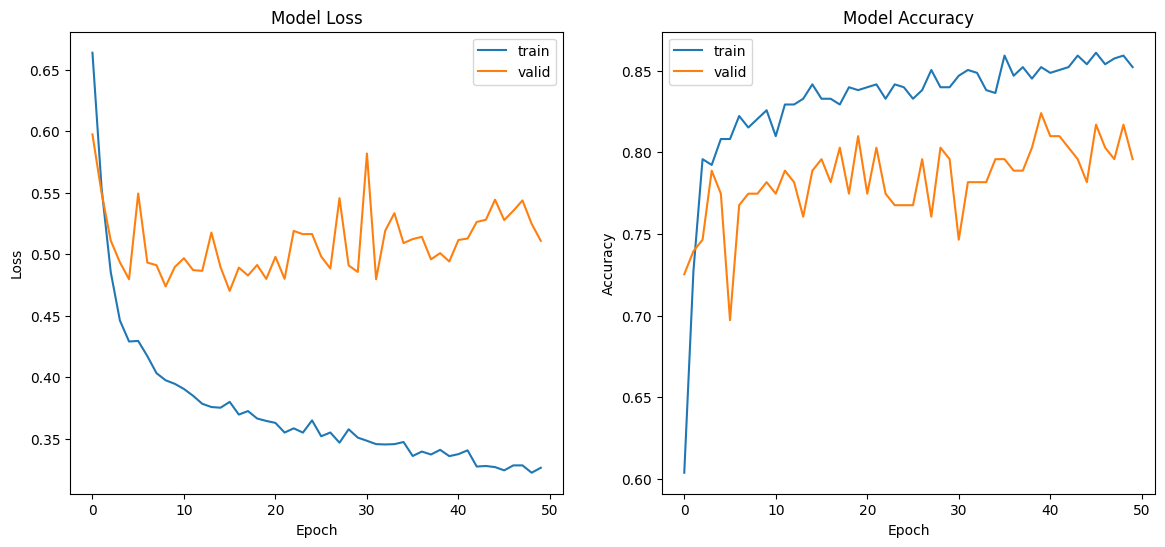

In [24]:
# Visulalize history
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plt.sca(ax[0])
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.sca(ax[1])
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Enhancing the model

In [25]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_final.shape[1],)),
    tf.keras.layers.Dropout(0.5, seed=97),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5, seed=97),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5, seed=97),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,545 (49.00 KB)

 Trainable params: 12,545 (49.00 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit(X_train_final, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping])


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.7877 - loss: 0.4542 - val_accuracy: 0.8028 - val_loss: 0.4796
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8159 - loss: 0.4404 - val_accuracy: 0.8028 - val_loss: 0.4774
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7973 - loss: 0.4325 - val_accuracy: 0.8028 - val_loss: 0.4696
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8146 - loss: 0.4770 - val_accuracy: 0.8028 - val_loss: 0.4763
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8150 - loss: 0.4510 - val_accuracy: 0.8028 - val_loss: 0.4894
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7990 - loss: 0.4617 - val_accuracy: 0.8028 - val_loss: 0.4858
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8251 - loss: 0.4451 - val_accuracy: 0.8028 - val_loss: 0.4828
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8108 - loss: 0.4598 - val_accuracy: 0.8028 -

In [38]:
test_loss , test_acc = model.evaluate(X_test_final, y_test)
test_loss , test_acc

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8478 - loss: 0.4019


(0.4370397627353668, 0.8370786309242249)

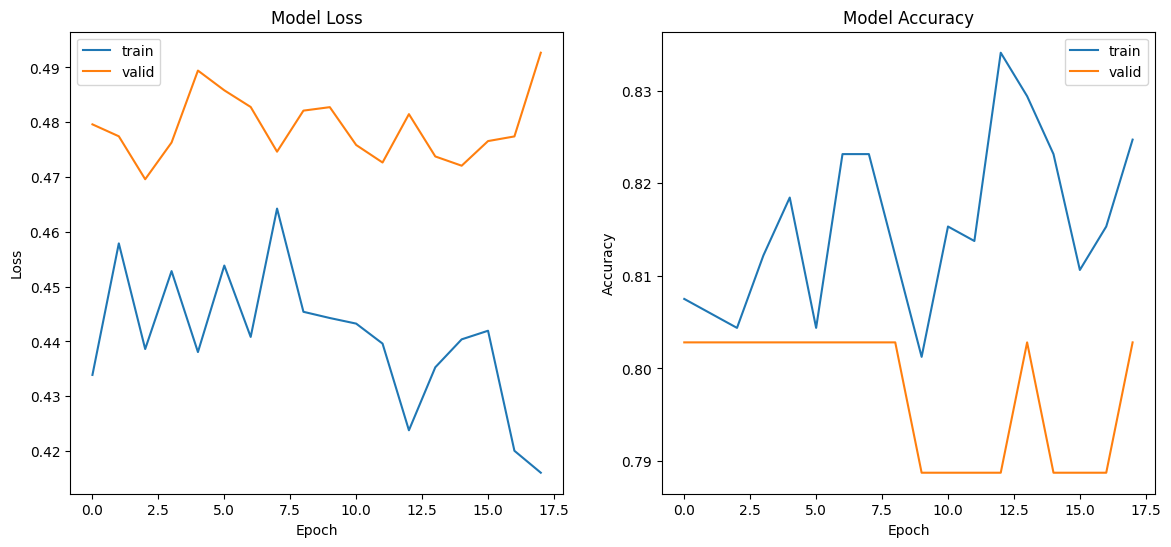

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plt.sca(ax[0])
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.sca(ax[1])
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Enhancing the model

In [40]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.01), input_shape=(X_train_final.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer="l2"),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer="l2"),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,545 (49.00 KB)

 Trainable params: 12,545 (49.00 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Fit
history = model.fit(X_train_final, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 283ms/step - accuracy: 0.6129 - loss: 2.2904 - val_accuracy: 0.6972 - val_loss: 1.9758
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7065 - loss: 1.9064 - val_accuracy: 0.7676 - val_loss: 1.6804
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7960 - loss: 1.5895 - val_accuracy: 0.7394 - val_loss: 1.4617
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7621 - loss: 1.3996 - val_accuracy: 0.7887 - val_loss: 1.2833
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8105 - loss: 1.2067 - val_accuracy: 0.7254 - val_loss: 1.1662
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8243 - loss: 1.0563 - val_accuracy: 0.7746 - val_loss: 1.0542
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8165 - loss: 0.9752 - val_accuracy: 0.7958 - val_loss: 0.9627
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7949 - loss: 0.9124 - val_accuracy: 0.7817 

In [42]:
test_loss , test_acc = model.evaluate(X_test_final, y_test)
test_loss , test_acc

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8032 - loss: 0.4832


(0.5180666446685791, 0.7977527976036072)

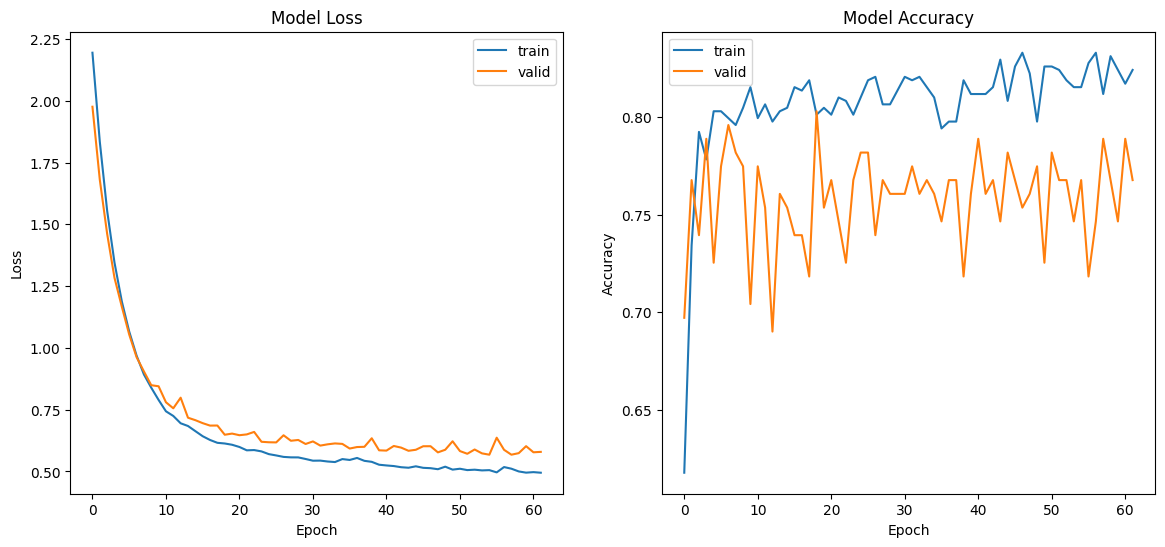

In [43]:
# Visulalize history
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plt.sca(ax[0])
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.sca(ax[1])
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Keras tuner

In [44]:
def build_model(hp):
    model = tf.keras.models.Sequential([

        # Input Layer (preferable)
        tf.keras.layers.Input(shape=(X_train_final.shape[1],)),

        # First Layer
        tf.keras.layers.Dense(units=hp.Int("units_1", min_value=32, max_value=256, step=32),
        activation="relu"),

        # Dropout
        tf.keras.layers.Dropout(hp.Float("dropout_1", min_value=0.0, max_value=0.5, step=0.1)),

        # Second Layer
        tf.keras.layers.Dense(units=hp.Int("units_2", min_value=32, max_value=256, step=32),
        activation="relu"),

        # Dropout
        tf.keras.layers.Dropout(hp.Float("dropout_2", min_value=0.0, max_value=0.5, step=0.1)),

        # Output Layer
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

    return model

In [45]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

In [52]:
tuner = RandomSearch(hypermodel=build_model,
                     objective="val_accuracy",
                     max_trials=10,
                     executions_per_trial=2,
                     directory="hyperparam_tuning",
                     project_name="titanic_tuning",
                     seed=174)

In [53]:
tuner.search(X_train_final, y_train,
             epochs=50,
             validation_split=0.2,
             callbacks=[early_stopping],
             )

Trial 10 Complete [00h 00m 14s]
val_accuracy: 0.8063380420207977

Best val_accuracy So Far: 0.8133803009986877
Total elapsed time: 00h 02m 52s


In [64]:
best_model = tuner.get_best_models(num_models=1)[0]
history = best_model.fit(X_train_final, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.8181 - loss: 0.4184 - val_accuracy: 0.7958 - val_loss: 0.4641
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7927 - loss: 0.4205 - val_accuracy: 0.8099 - val_loss: 0.4637
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8058 - loss: 0.4189 - val_accuracy: 0.7746 - val_loss: 0.4906
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8376 - loss: 0.3907 - val_accuracy: 0.8099 - val_loss: 0.4741
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8319 - loss: 0.3932 - val_accuracy: 0.8169 - val_loss: 0.4651
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8251 - loss: 0.3900 - val_accuracy: 0.7606 - val_loss: 0.4724
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8241 - loss: 0.3686 - val_accuracy: 0.7887 - val_loss: 0.4819
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8289 - loss: 0.3652 - val_accuracy: 0.8099 - 

In [65]:
test_loss , test_acc = best_model.evaluate(X_test_final, y_test)
test_loss , test_acc

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8183 - loss: 0.3877


(0.42588651180267334, 0.8146067261695862)

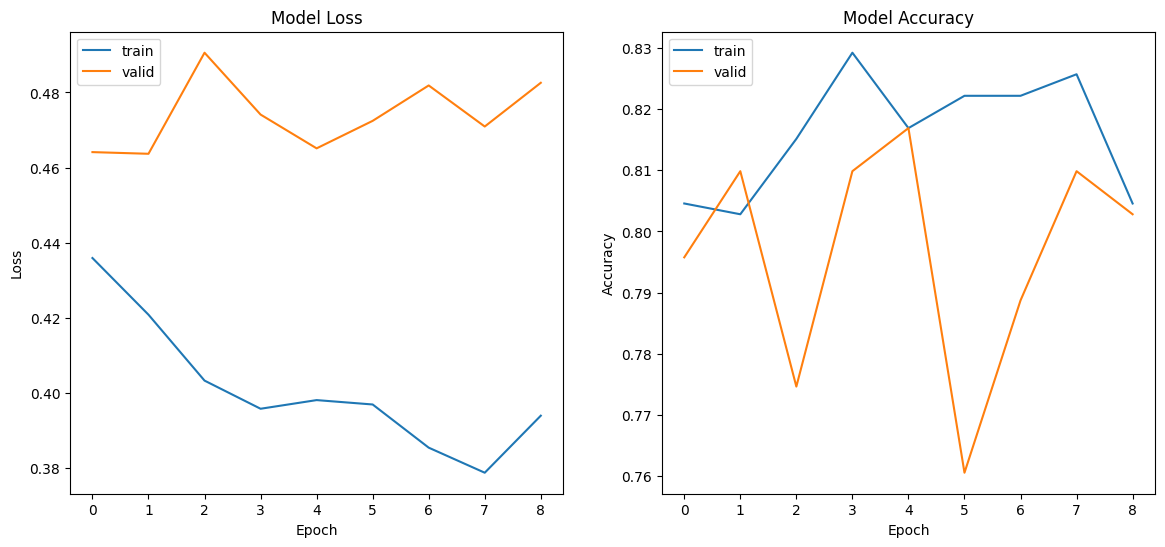

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plt.sca(ax[0])
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.sca(ax[1])
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Save the best model

In [ ]:
best_model.save(os.path.join(models_path, "best_model.keras"))

In [68]:
model = tf.keras.models.load_model(os.path.join(models_path, "best_titanic_model.keras"))
test_loss, test_acc = best_model.evaluate(X_test_final, y_test)
test_loss, test_acc

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8183 - loss: 0.3877 


(0.42588651180267334, 0.8146067261695862)

In [73]:
samples = data.sample(10, random_state=42)
samples_processed = preprocessor.transform(samples)
predictions = (model.predict(samples_processed) > 0.5).astype("int32")
predictions.flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1], dtype=int32)

In [74]:
results = pd.DataFrame({
    'Passenger_ID': samples["passengerid"],
    'Actual': samples["survived"],
    'Predicted': ['Survived' if pred == 1 else 'Not Survived' for pred in predictions.flatten()],
})

results

,Passenger_ID,Actual,Predicted
709,710,1,Not Survived
439,440,0,Not Survived
840,841,0,Not Survived
720,721,1,Survived
39,40,1,Survived
290,291,1,Survived
300,301,1,Survived
333,334,0,Not Survived
208,209,1,Survived
136,137,1,Survived
